<a href="https://colab.research.google.com/github/CFIN-analysis/analysis_workshop_26May/blob/main/Notebooks//3_4_Testing_across_visits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Across-State-Visits Testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)
In this tutorial, we’ll explore how to perform across-state-visits testing using the [GLHMM toolbox](https://github.com/vidaurre/glhmm), based on the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). This test is useful for examining whether brain states, decoded from neural data, are associated with changes in a continuous variable recorded alongside the brain activity.

To focus on the statistical testing, we use synthetic data:

For this tutorial:

* $D$: the Viterbi path — the sequence of brain states decoded by an HMM at each time point.

* $R$: a continuous signal recorded alongside the brain data (e.g., pupil size, heart rate).

> **Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_visits.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>

## Table of Contents
1. [Preparation](#preparation)
2. [Load data](#load-data)
3. [Across-Visits testing - Monte Carlo resampling](#across-visits)
    * [Multivariate](#perm-regression)
    * [Univariate](#perm-correlation)
    * [One-state-vs-the-rest (OSR)](#perm-rest)
    * [One-state-vs-another-state (OSA)](#perm-pairs)

# Preparation <a id="preparation"></a>

If you don't have the **GLHMM package** installed, this notebook will help you install it automatically.

We will also download example data from the Open Science Framework (OSF).

---


In [26]:
# Install packages if needed
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Installing GLHMM...")
    !pip install git+https://github.com/vidaurre/glhmm

# Install osfclient if missing
try:
    import osfclient
except ImportError:
    print("Installing osfclient...")
    !pip install osfclient

# Now import everything we need
import numpy as np
from pathlib import Path
from glhmm import glhmm,graphics, statistics


# Load and Prepare Data <a id="load-data"></a>
To get started, we’ll download the synthetic data. If they already exist, we will skip downloading.

We’ll use the `osfclient` package to fetch the files directly from the Open Science Framework (OSF). If you prefer, you can also download them manually from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666).

In [3]:
# Set up data directory
data_dir = Path.cwd() / "files" / "data_statistical_testing"

if not data_dir.exists():
    print(f"Creating {data_dir}...")
    data_dir.mkdir(parents=True, exist_ok=True)
else:
    print(f"Data directory {data_dir} already exists.")

# Files to download
files = [
    "vpath.npy",
    "sig_data.npy",
]

# Download the files from OSF if they don't exist locally
for fname in files:
    local_path = data_dir / fname
    remote_path = f"data_statistical_testing/{fname}"

    if local_path.exists():
        print(f"✓ {fname} already exists — skipping.")
    else:
        print(f"Downloading {fname}...")
        # as_posix() ensures forward slashes on Windows for shell compatibility
        !osf -p 8qcyj fetch {remote_path} {local_path.as_posix()}


Data directory c:\Users\au323479\Github\analysis_workshop_26May\Notebooks\files\data_statistical_testing already exists.
✓ vpath.npy already exists — skipping.
✓ sig_data.npy already exists — skipping.


**Load and check the data**\
The folder `data_statistical_testing` contains:

- **`vpath`**: decoded HMM state sequence (Viterbi path)  
  Shape: **(n_timepoints, K)** — here **5000 × 5**, where 5000 timepoints are decoded into 5 possible HMM states.  
  Each row represents a timepoint; each column of `K` corresponds to a specific state.

- **`sig_data`**: simulated continuous signal recorded alongside the brain data  
  Shape: **(n_timepoints, 1)** — a 1D array with one value per timepoint.


> **Note**: For details on training from scratch, follow the tutorials [*Standard Gaussian Hidden Markov Model*](./GLHMM_example.ipynb) or [*Gaussian-Linear Hidden Markov Model*](./GLHMM_example.ipynb). In this notebook, we use precomputed Viterbi path to focus on the across-state-visits testing.

If you wish to compute the Viterbi path yourself after training a model (`hmm_model`), you can use the following code:

```python
vpath = hmm_model.decode(X=None, Y=D_data, indices=idx, viterbi=True)

Let’s load the files into memory:

In [4]:
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "files"/ "data_statistical_testing"

# Data
vpath = np.load(PATH_DATA/"vpath.npy")
sig_data = np.load(PATH_DATA/"sig_data.npy")

**Check the shape of each dataset**
This step helps confirm that all files loaded correctly and match the expected dimensions.

In [5]:
# Check that dimensions are correct
print(f"Data dimension of vpath: {vpath.shape}")
print(f"Data dimension of sig_data: {sig_data.shape}")

Data dimension of vpath: (5000, 5)
Data dimension of sig_data: (5000, 1)


### Visualise Viterbi path
Now, let's visualise the distinct states in the Viterbi path from our trained Hidden Markov Model.

The plot provides a clear depiction of each time point assigned to a specific HMM state, with each state represented by a distinct color. This visualisation allows us to easily discern the temporal distribution and transitions between different states.

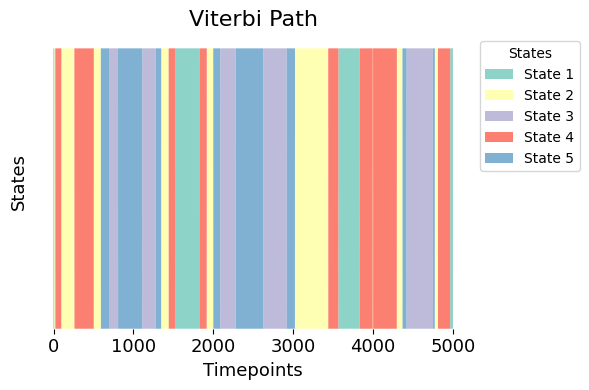

In [6]:
graphics.plot_vpath(vpath, figsize=(6,4), ylabel="States")

**Plot Viterbi path and discrete states**\
The next plot shows the sequence of brain states identified by the Hidden Markov Model (HMM) over time—this is known as the Viterbi path. Each state is represented by a different background color, making it easy to see when the model switches between states.

The black line overlaid on the plot simply traces the discrete state assignments over time. Its position on the y-axis shows which state was active at each time point. For example, if the black line is at y = 5 during a blue segment, it means that time point was assigned to State 5 by the model.

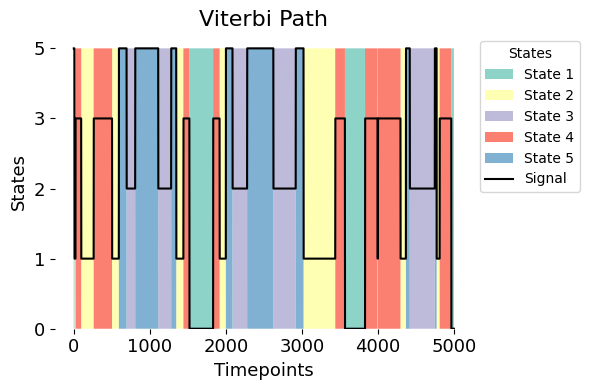

In [7]:
# Create a 1D array from the one-hot encoded Viterbi path data
vpath_1D=statistics.generate_vpath_1D(vpath)

# Plot discrete states with the Viterbi path
graphics.plot_vpath(vpath,vpath_1D, figsize=(6,4), ylabel="States", yticks=True)

**Plot Viterbi path and signal**\
This plot shows the Viterbi path (D) together with the signal (R). Each time point is color-coded based on the brain state assigned by the HMM, making it easy to compare the signal and the state changes.

To create this plot, the signal data is adjusted to fit on the same scale as the Viterbi path (from 0 to 1). This adjustment is just for visualisation, helping us overlay the two and see how well the model reflects the patterns in the signal.

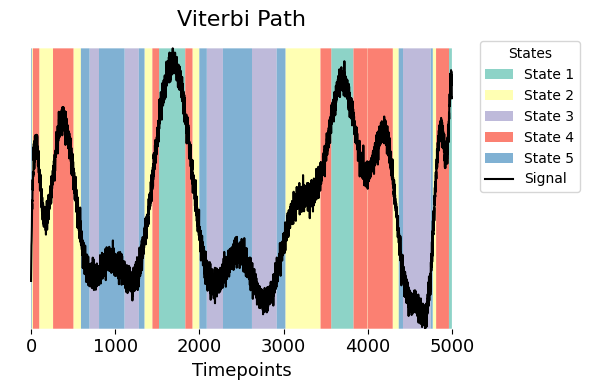

In [8]:
# Plot vpath and sig_data
graphics.plot_vpath(vpath,sig_data, figsize=(6,4))

One way to explore what each state represents is to look at how the continuous signal behaves when the system is in that state. Using the Viterbi path, we assign each time point in the signal to a state.

We can then calculate the average signal value for each state by taking the mean of the signal across all time points assigned to that state. This helps us understand the typical signal level associated with each state and gives an initial sense of how the states differ from one another.

In [9]:
vpath_1D=statistics.generate_vpath_1D(vpath)
val_state =[np.mean(sig_data[vpath_1D == i+1]) for i in range(vpath.shape[1]) ]
val_state

[np.float64(4.912042797300882),
 np.float64(-0.05858422375450776),
 np.float64(-3.795696791047377),
 np.float64(2.352225972831181),
 np.float64(-2.5030418147224505)]

The above figure shows a relation between the simulated measurements (```sig_data```) and the Viterbi path (```vpath```). Notably, a closer examination of the variable ```val_state``` shows distinct values assigned to each specific state: 

* State 1 (green) aligns with highest value 
* State 2 (yellow) corresponds to values in the middle, close to 0. 
* State 3 (purple) corresponds to the lowest negative values.
* States 4 (red) and State 5 (blue) are values that fall between the extremes values. 
This gives us a perspective on the behavioral dynamics across different states on our signal.

# **3. Across-Visits testing - Monte Carlo resampling** <a id="across-visits"></a>
As we move on to the next part of this tutorial, let's dive into how we can use the ```test_across_state_visits``` function.
This function helps us to find connections between HMM state time course (`D`) and behavioral variables or individual traits (`R`) using Monte Carlo resampling.


**Monte Carlo resampling**\
Monte Carlo resampling creates a null distribution without making any assumptions about the data.

## **Across visits - Multivariate** <a id="perm-regression"></a>

This multivariate analysis tests whether the sequence of states (`K`) identified by the Viterbi path (D_data), which was inferred from the brain data using an HMM, can explain variability in a separate signal (R_data) recorded simultaneously (e.g., pupil size or behavioral responses). Importantly, the HMM is not fitted to this signal — it is trained only on the brain data — so the analysis avoids circularity.

To test the relationship, we compare the signal values across states and assess whether the observed differences are greater than what would be expected by chance. Statistical significance is determined using Monte Carlo resampling, where we randomly shuffle the state assignments. A significant result suggests that the brain state dynamics are meaningfully linked to the external signal.

To run the test, use the `across_state_visits` function by providing the inputs:

**Inputs**:

* ```D_data```: The Viterbi path of the brain data (`vpath`) with shape [n_timepoints, K]
* ```R_data```: The simulated signal that is measured in parallel with shape [n_timepoints, 1]

**Settings**:

* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nnull_samples```: Number of samples (optional, default is 1000).

For details on additional settings, refer to the function documentation.

In [12]:
# Set the parameters for across_visits testing
method = "multivariate"
Nnull_samples = 10_000 # Number of resamples (default = 1000)
result_multivariate  =statistics.test_across_state_visits(vpath, 
                                                          sig_data, 
                                                          method=method,
                                                          Nnull_samples=Nnull_samples)

100%|██████████| 10000/10000 [00:13<00:00, 737.13it/s]


The result is stored in a dictionary called `result_multivariate`. Here's what it contains:

* ```pval```: array of p-values with shape `(1, q)`, where each number of `q` corresponds to a behavioral variable. See the [GLHMM paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python) for details.

* ```base_statistics```: test statistics computed from the original (unshuffled) data. For multivariate tests, this corresponds to the F-statistic.

* ```null_stat_distribution```: array of test statistics obtained from each Monte Carlo resampling.

* ```statistical_measures```: dictionary indicating which statistic was used (e.g., F-statistic).

* ```test_type```: Indicates the type of statistical test performed. In this case, it is ```across_visits```.

* ```method```:  test method used, here it is `"multivariate"`

* ```max_correction```: whether MaxT correction was applied during Monte Carlo resampling.

* ```Nnull_samples```: number of Monte Carlo samples used to generate the null distribution.

* ```test_summary```: structured summary of the results, including F-statistics and model coefficients.



**Visualisation of results**\
Now that we have performed our test, we can then visualise the p-value array.\
We will import the function ```plot_p_values_bar``` from module ```graphics.py```
> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.

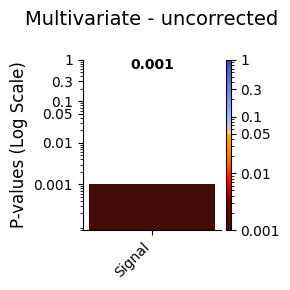

In [13]:
# Plot p-values
graphics.plot_p_values_bar(result_multivariate["pval"], 
                           title_text ="Multivariate - uncorrected",
                           figsize=(3, 3), 
                           alpha=0.05, 
                           xticklabels=["Signal"])

#### Conclusion - Multivariate
The multivariate test between the Viterbi path and the signal resulted in a statistically significant p-value. This indicates a meaningful relationship between the brain states identified by the HMM and the signal, suggesting that the states capture important dynamics related to the observed data.

## **Across visits - Univariate** <a id="perm-correlation"></a>

The univariate analysis evaluates pairwise relationships between discrete states in the Viterbi path (```D_data```) and the variability in the signal (```R_data```). Each state is tested individually against the signal, resulting in one p-value per state. For example, with 5 states and 1 signal, the test will produce 5 p-values.

The goal is to assess whether specific states in the Viterbi path significantly contribute to changes in the signal values over time. A Monte Carlo resampling determines the statistical significance of these relationships:

To run the test, we set the following parameters:

**Inputs**:


* ```D_data```: The Viterbi path of the brain data (`vpath`) with shape [n_timepoints, K]
* ```R_data```: The simulated signal that is measured in parallel with shape [n_timepoints, 1]

**Settings**:

* ```method = "univariate"```: Specifies that the test should perform univariate analysis.
* ```Nnull_samples```: Number of samples (optional, default is 1000).

The function ```test_across_state_visits``` is used as follows:


In [14]:
# Set the parameters for across_visits testing
method = "univariate"
Nnull_samples = 10_000
result_univariate  =statistics.test_across_state_visits(vpath, 
                                                        sig_data, 
                                                        method=method,
                                                        Nnull_samples=Nnull_samples)

100%|██████████| 10000/10000 [00:15<00:00, 644.34it/s]


**Visualisation of results**\
We can now plot the p-values over time using the `plot_p_values_bar` function from the `graphics` module.

> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.


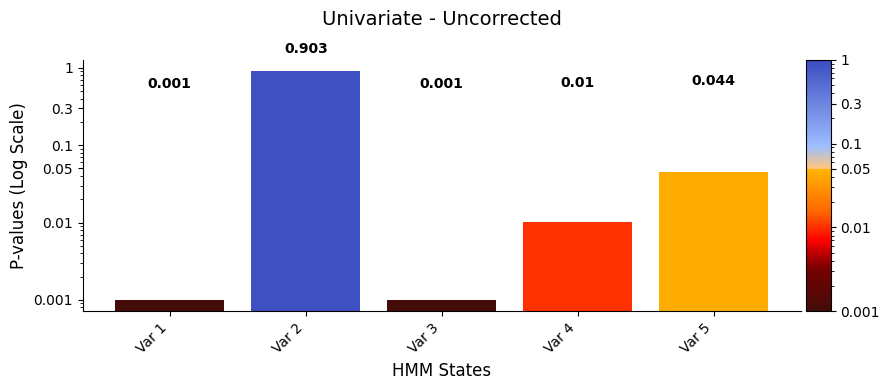

In [15]:
# Plot p-values
graphics.plot_p_values_bar(result_univariate["pval"], 
                           title_text ="Univariate - Uncorrected",
                           xlabel="HMM States", 
                            )

**Multiple Comparisons**\
To correct for Type I error, we can apply the Benjamini/Hochberg procedure to control the False Discovery Rate (FDR).

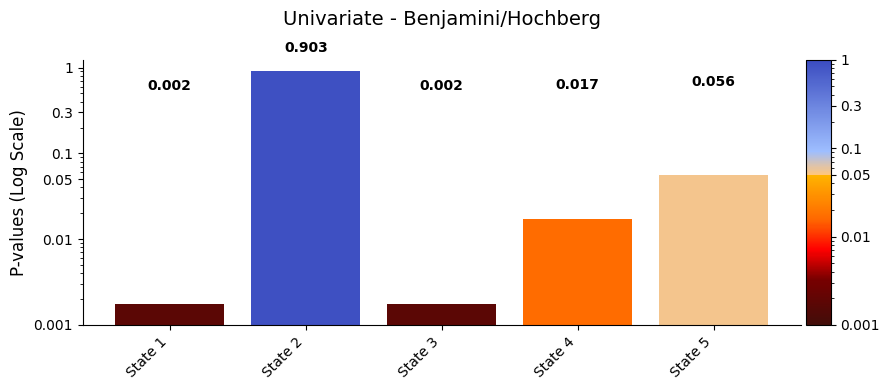

In [16]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate, 
                                                               method='fdr_bh')
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(pval_corrected))] # construct the variable names
graphics.plot_p_values_bar(pval_corrected,
                           alpha = alpha, 
                           xticklabels=variables, 
                           title_text="Univariate - Benjamini/Hochberg")

**Plot Monte Carlo resampling distribution**\
Presented here are the test statistics(```result["null_stat_distribution"]```) of our Monte Carlo resampling distributions for different states.\
The red line shows the observed statistic, while the datapoints of the histogram represent the Monte Carlo resampling distribution

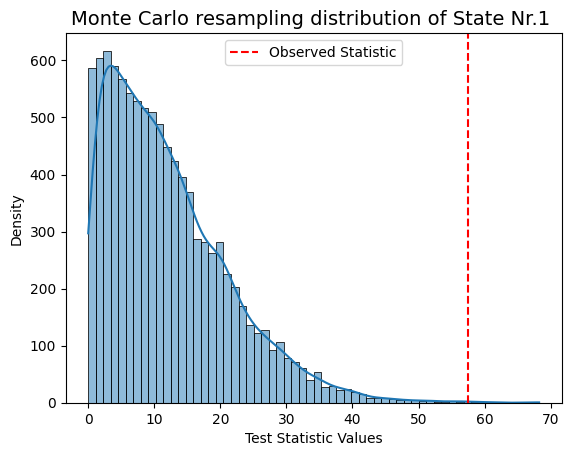

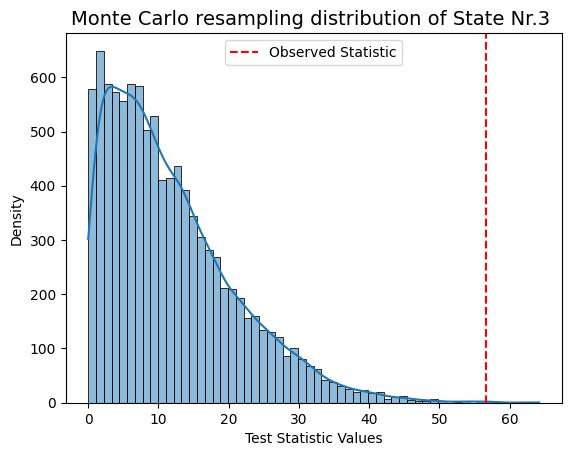

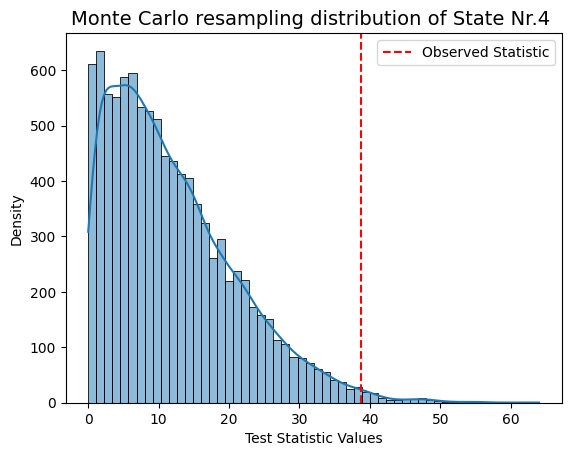

In [17]:
# Plot test statistics for pvals
significant_timestamp_position = np.where(pval_corrected < alpha)
for i in significant_timestamp_position[0]:
    graphics.plot_permutation_distribution(result_univariate["null_stat_distribution"][:,i],
                                           title_text=f"Monte Carlo resampling distribution of State Nr.{i+1} ")

#### Conclusion - Univariate
The results show that states 1, 3, and 4 have a significant relationship with the signal, while states 2 and 5 do not. The signal's highest peak aligns with state 1, the lowest with state 3, and the second-highest with state 4, supporting these findings.

This suggests that states with extreme signal values have a stronger influence on the signal's changes, while states 2 and 5 may have a weaker or less clear impact.


## **Across visits -  One-state-vs-the-rest (OSR)** <a id="perm-rest"></a>
The OSR test assesses whether a specific state in the Viterbi path (`D_data`) significantly differs from the combined influence of all other states on the signal (`R_data`). This test generates five p-values, one for each state.

By default, the test checks if a state is larger than the rest using `state_com='larger'`. To test if a state is smaller, set `state_com='smaller'`.

**Inputs**:

* ```D_data```: The Viterbi path of the brain data (`vpath`) with shape [n_timepoints, K]
* ```R_data```: The simulated signal that is measured in parallel with shape [n_timepoints, 1]

**Settings**:

* ```method = "ors"```: Specifies that the test should perform One-state-vs-the-rest test.
* ```Nnull_samples```: Number of resamples (optional, default is 1000).


In [18]:
# Set the parameters for across_visits testing
method = "osr"
Nnull_samples = 10_000

result_one_vs_rest  =statistics.test_across_state_visits(vpath, 
                                                         sig_data, 
                                                         method=method,
                                                         Nnull_samples=Nnull_samples)

100%|██████████| 10000/10000 [00:12<00:00, 809.81it/s]


**Visualisation of results**\
We can now plot the p-values over time using the `plot_p_values_bar` function from the `graphics` module.

> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.


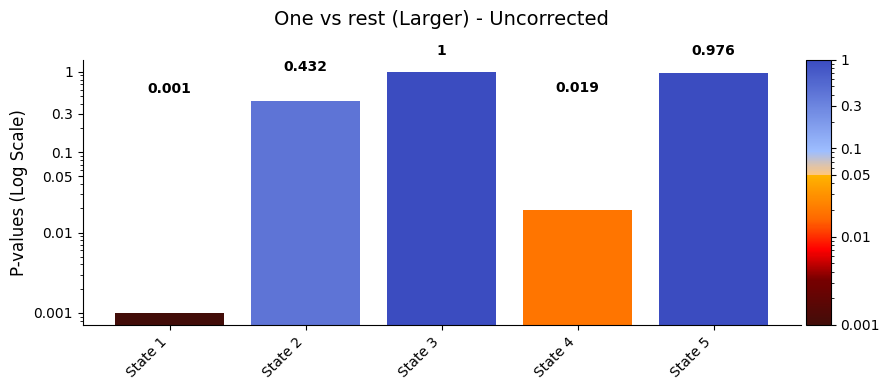

In [19]:
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(result_one_vs_rest["pval"]))] # construct the variable names
title_text = "One vs rest (Larger) - Uncorrected"
graphics.plot_p_values_bar(result_one_vs_rest["pval"],
                           alpha = alpha, 
                           xticklabels=variables, 
                           title_text=title_text)

**Multiple Comparison**\
To correct for Type I error, we can apply the Benjamini/Hochberg procedure to control the False Discovery Rate (FDR).

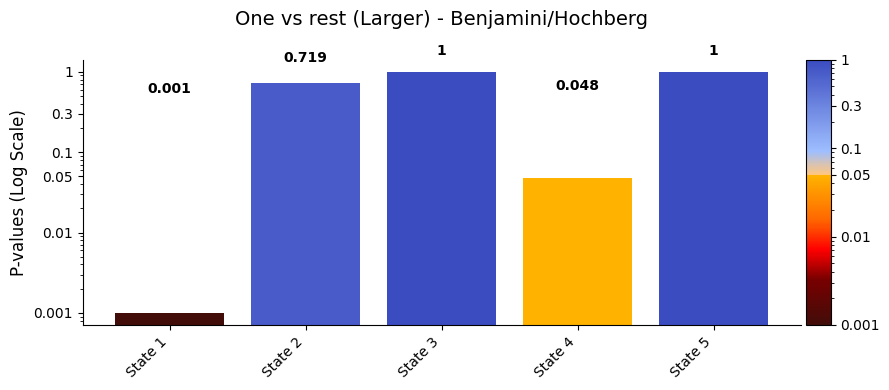

In [20]:
pval_corrected, _ =statistics.pval_correction(result_one_vs_rest, 
                                              method='fdr_bh')
# Plot p-values
graphics.plot_p_values_bar(pval_corrected,alpha = alpha, 
                           xticklabels=variables, 
                           title_text="One vs rest (Larger) - Benjamini/Hochberg")


In [21]:
val_state

[np.float64(4.912042797300882),
 np.float64(-0.05858422375450776),
 np.float64(-3.795696791047377),
 np.float64(2.352225972831181),
 np.float64(-2.5030418147224505)]

#### Conclusion - One vs rest
After applying the Benjamini/Hochberg method to control the False Discovery Rate (FDR), the adjusted p-values for the one vs. rest test are:

* State 1: 0.005 
* State 2: 0.724  
* State 3: 1 
* State 4: 0.048
* State 5: 1

States 1 and 4, which have the lowest adjusted p-values, also show the highest average signal values in `sig_data`. In the `ORS`, we check whether the mean signal for a given state is significantly different from the combined signal of all other states. A state doesn’t need to have the highest or lowest mean to be significant — what matters is whether its signal is consistently different from the rest, more than you’d expect by chance. That said, states with more extreme values often stand out more clearly from the shuffled data, so they’re more likely to reach significance.

## **Across visits - One-state-vs-another-state (OSA)** <a id="perm-pairs"></a>
The OSA test compares the mean signal differences between pairs of states (e.g., state 1 vs. state 2, state 1 vs. state 3, etc.). This test evaluates whether the observed mean difference between specific state pairs is statistically significant.


**Inputs**:

* ```D_data```: The Viterbi path of the brain data (`vpath`) with shape [n_timepoints, K]
* ```R_data```: The simulated signal that is measured in parallel with shape [n_timepoints, 1]

**Settings**:

* ```method = "osa"```: Specifies that the test should perform one-state-vs-another-state test.
* ```Nnull_samples```: Number of resamples (optional, default is 1000).

In [22]:
# Set the parameters for across_visits testing
method = "osa"
Nnull_samples = 10_000
test_statistics_option=True

result_state_pairs  =statistics.test_across_state_visits(vpath, 
                                                         sig_data, 
                                                         method=method,
                                                         Nnull_samples=Nnull_samples,)

Pairwise comparisons: 100%|██████████| 10/10 [01:24<00:00,  8.50s/it]


**Visualisation of results**\
Now that we have performed our test, we can then visualise the p-value array.
We will plot the p-values using the function ```plot_p_value_matrix```. Notably, we set the diagonal values in the pairwise comparison matrix to NaN for visualisation. These entries correspond to comparisons where a state is tested against itself. Since this involves subtracting the mean signal of a state from itself, the result is always zero — meaning there's no meaningful difference to test. We mark these values as NaN to avoid misleading interpretations and to keep the focus on comparisons between different states.

> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.


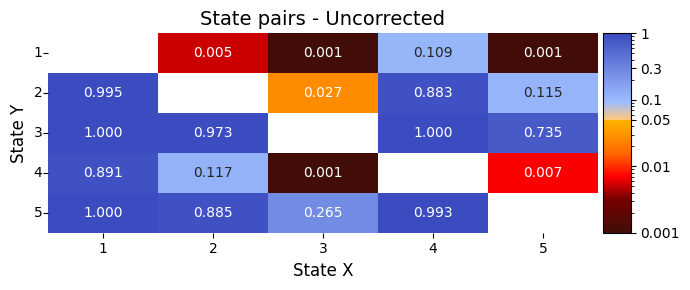

In [23]:
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(result_state_pairs["pval"], 
                             title_text ="State pairs - Uncorrected",
                             figsize=(7, 3), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True,
                             x_tick_min=1)

**Interpreting the p-value matrix**\
The p-value matrix has a shape of (number of states × number of states). Each entry shows the statistical comparison between two brain states.

* **Values below the diagonal** (lower-left) correspond to tests where the row state is compared as less than the column state (State X < State Y).

* **Values above the diagonal** (upper-right) correspond to tests where the row state is compared as greater than the column state (State X > State Y).

**Multiple Comparison**\
To correct for Type I error, we can apply the Benjamini/Hochberg procedure to control the False Discovery Rate (FDR).

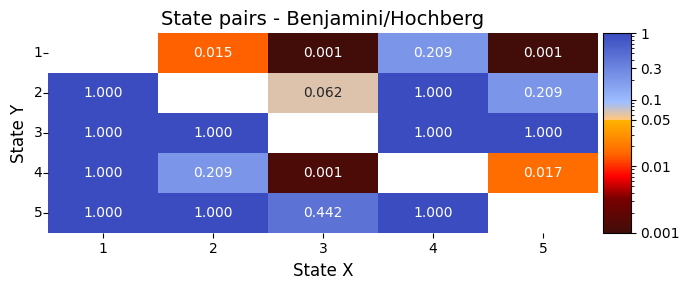

In [24]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_state_pairs, method='fdr_bh')
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, 
                             title_text ="State pairs - Benjamini/Hochberg" ,
                             figsize=(7, 3), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True,
                             x_tick_min=1)

In [25]:
# Look at the val_sates values
val_state

[np.float64(4.912042797300882),
 np.float64(-0.05858422375450776),
 np.float64(-3.795696791047377),
 np.float64(2.352225972831181),
 np.float64(-2.5030418147224505)]

#### Conclusion - state pairs
The results show clear differences in the signal between certain pairs of brain states:

* **State 1** (the highest signal value) is significantly different from states 2, 3, and 5.
* **State 3** (the lowest signal value) is significantly different from states 1 and 4.
* **States 4 and 5**, which are in the middle, also show a clear difference from each other and from state 1.

These differences suggest that specific pairs of brain states are linked to noticeable changes in the signal. This could help us understand how the signal shifts during transitions between states, such as when studying responses to pain.
